In [1]:
import pandas as pd
import matplotlib.pyplot as plt

folder = "data/"
year = "2016"
files = ["usagers_", "vehicules_","lieux_", "caracteristiques_"]

dfs = []

for file in files:
    print( "loading database", file + year )
    df = pd.read_csv( folder + file + year + ".csv", delimiter =',', encoding='latin1')
    dfs.append(df)


loading database usagers_2016
loading database vehicules_2016
loading database lieux_2016
loading database caracteristiques_2016


D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
import numpy as np
import scipy.stats as scs
import plotly.graph_objs as go
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

In [3]:
def mosaic_plot(df, dic_color_row, row_labels=None, col_labels=None, alpha_label=None, top_label="Size",
                x_label=None, y_label=None, pad_x=0.01, pad_y=0.01, color_ylabel=False, ax=None, order="Size",
                figsize=None, phat=None, lines=[]):
    """ 

    From a contingency table NxM, plot a mosaic plot with the values inside. There should be a double-index for rows
    e.g.
                                         3   4   1   0   2  5
        Index_1          Index_2                       
        AA               C               0   0   0   2   3  0
                         P               6   0   0  13   0  0
        BB               C               0   2   0   0   0  0
                         P              45   1  10  10   1  0
        CC               C               0   6  35  15  29  0
                         P               1   1   0   2   0  0
        DD               C               0  56   0   3   0  0
                         P              30   4   2   0   1  9

    order: how columns are order, by default, from the biggest to the smallest in term of category. Possible values are 
        - "Size" [default]
        - "Normal" : as the columns are order in the input df
        - list of column names to reorder the column
    top_label: Size of each columns. The label can be changed to adapt to your value. 
               If `False`, nothing is displayed and the secondary legend is set on top instead of on right.
               
    lines: iterable of couples (y, format, params) : plots supplementary lines (eg to indicate average and uncertainties)
    """

    is_multi = len(df.index.names) == 2
    if ax == None:
        if figsize == None:
            figsize = (len(df.columns), len(df.index.get_level_values(0).unique()))
        fig, ax = plt.subplots(1,1, figsize=figsize)

    size_col = df.sum().sort_values(ascending=False)
    prop_com = size_col.div(size_col.sum())

    if order == "Size":
        df = df[size_col.index.values]
    elif order == "Normal":
        prop_com = prop_com[df.columns]
        size_col = size_col[df.columns]
    else:
        df = df[order]
        prop_com = prop_com[order]
        size_col = size_col[order]

    if is_multi:
        inner_index = df.index.get_level_values(1).unique()
        prop_ii0 = (df.swaplevel().loc[inner_index[0]]/(df.swaplevel().loc[inner_index[0]]+df.swaplevel().loc[inner_index[1]])).fillna(0)
        alpha_ii = 0.5
        true_y_labels = df.index.levels[0]
    else:
        alpha_ii = 1
        true_y_labels = df.index

    Yt = (df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())+pad_y).cumsum() - pad_y
    Ytt = df.groupby(level=0).sum().iloc[:,0].div(df.groupby(level=0).sum().iloc[:,0].sum())

    x = 0    
    for j in df.groupby(level=0).sum().iteritems():
        bot = 0
        S = float(j[1].sum())
        for lab, k in j[1].iteritems():
            bars = []
            ax.bar(x, k/S, width=prop_com[j[0]], bottom=bot, color=dic_color_row[lab], alpha=alpha_ii, lw=0, align="edge")
            if is_multi:
                ax.bar(x, k/S, width=prop_com[j[0]]*prop_ii0.loc[lab, j[0]], bottom=bot, color=dic_color_row[lab], lw=0, alpha=1, align="edge")
            bot += k/S + pad_y
        x += prop_com[j[0]] + pad_x

    ## Aesthetic of the plot and ticks
    # Y-axis
    if row_labels == None:
        row_labels = Yt.index
    ax.set_yticks(Yt - Ytt/2)
    ax.set_yticklabels(row_labels)

    ax.set_ylim(0, 1 + (len(j[1]) - 1) * pad_y)
    if y_label == None:
        y_label = df.index.names[0]
    ax.set_ylabel(y_label)

    # X-axis
    if col_labels == None:
        col_labels = prop_com.index
    xticks = (prop_com + pad_x).cumsum() - pad_x - prop_com/2.
    ax.set_xticks(xticks)
    ax.set_xticklabels(col_labels)
    ax.set_xlim(0, prop_com.sum() + pad_x * (len(prop_com)-1))

    if x_label == None:
        x_label = df.columns.name
    ax.set_xlabel(x_label)

    # Top label
    if top_label:
        ax2 = ax.twiny()
        ax2.set_xlim(*ax.get_xlim())
        ax2.set_xticks(xticks) 
        ax2.set_xticklabels(size_col.values.astype(int))
        ax2.set_xlabel(top_label)
        ax2.tick_params(top=False, right=False, pad=0, length=0)

    # Ticks and axis settings

    ax.tick_params(top=False, right=False, pad=5)
    sns.despine(left=0, bottom=False, right=0, top=0, offset=3)

    # Legend
    if is_multi: 
        if alpha_label == None:
            alpha_label = inner_index
        bars = [ax.bar(np.nan, np.nan, color="0.2", alpha=[1, 0.5][b]) for b in range(2)]
        if top_label:
            plt.legend(bars, alpha_label, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, )
        else:
            plt.legend(bars, alpha_label, loc="lower center", bbox_to_anchor=(0.5, 1), ncol=2)
    plt.tight_layout(rect=[0, 0, .9, 0.95])
    if color_ylabel:
        for tick, label in zip(ax.get_yticklabels(), true_y_labels):
            tick.set_bbox(dict( pad=5, facecolor=dic_color_row[label]))
            tick.set_color("w")
            tick.set_fontweight("bold")
    for y, form, param in lines:
        plt.plot([0, 1], [y, y], form, **param)
    return ax

D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:780: RuntimeWarning:

invalid value encountered in greater_equal

D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:781: RuntimeWarning:

invalid value encountered in less_equal



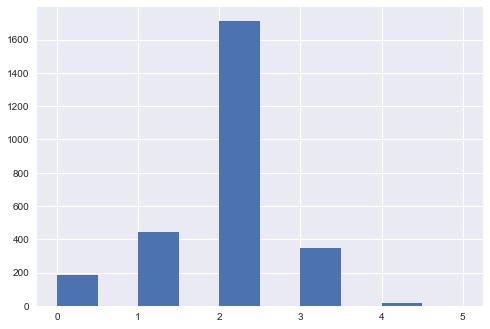

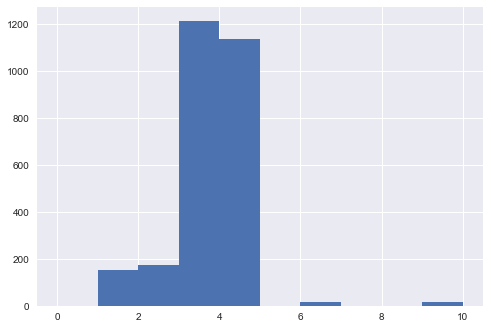

In [4]:
# Contresens
car_lieux = dfs[0].merge(dfs[2], on="Num_Acc")
contresens = pd.unique(dfs[1]["Num_Acc"].values[dfs[1]["manv"].values == 5])
circ_contresens = car_lieux["circ"].values[car_lieux["Num_Acc"].isin(contresens)]
plt.hist(circ_contresens, range=(0,5))
plt.show()

catr_contresens = car_lieux["catr"].values[car_lieux["Num_Acc"].isin(contresens)]
plt.hist(catr_contresens, range=(0,10))
plt.show()

In [5]:
accidents = dfs[2].merge(dfs[0], how="inner")
plt.hist(accidents["catr"][ (accidents["grav"] == 2) & (accidents["catr"] < 5)])
plt.xticks([1.15, 2.05, 2.95, 3.85], ["autoroute", "nationale", "départementale", "communale"])
plt.title("Nombre de morts en fonction du type de route")

# Jour 2, tests Valentin et Marie

Nombre d’accidents : 20741
Nombre personnes impliquées : 47096
Nombre de morts : 2492 
Nombre de morts ou blessés graves : 17344
\begin{tabular}{lrr}
\toprule
sexe\_cond &         1 &         2 \\
grav &           &           \\
\midrule
1    &  0.361042 &  0.363512 \\
2    &  0.058139 &  0.037220 \\
3    &  0.320859 &  0.297334 \\
4    &  0.259960 &  0.301933 \\
\bottomrule
\end{tabular}




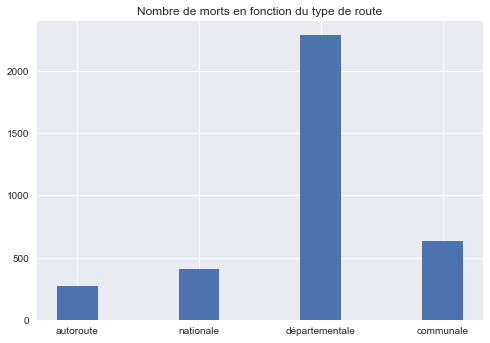

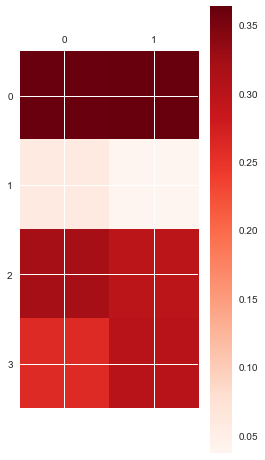

In [6]:
routes_nat_dep = dfs[2]['catr'].isin({2, 3})
tpc = dfs[2]['circ'] == 3 #Est bidirectionnelle
nat_dep_non_tpc = routes_nat_dep & ~tpc
print("Nombre d’accidents : %d" % nat_dep_non_tpc.sum())

accidents_int = dfs[2][nat_dep_non_tpc].merge(dfs[0], how="inner")
print("Nombre personnes impliquées : %d" % accidents_int.shape[0])

accidents_int["mort"] = (accidents_int["grav"] == 2)
accidents_int["grav_fatal"] = accidents_int["grav"].isin({2,3})
print("Nombre de morts : %d " % sum(accidents_int["mort"]))
print("Nombre de morts ou blessés graves : %d" % sum(accidents_int["grav_fatal"]))

vehicules_usagers = dfs[1].merge(dfs[0])
vehicules_conducteurs = vehicules_usagers[vehicules_usagers["catu"] == 1]
vehicules_conducteurs = vehicules_conducteurs[["Num_Acc", "num_veh", "sexe", "an_nais"]]
vehicules_conducteurs = vehicules_conducteurs.rename(columns={"sexe": "sexe_cond",
                                                              "an_nais": "an_nais_cond"
                                                             })
accidents_int = accidents_int.merge(vehicules_conducteurs, how="inner", on=("Num_Acc", "num_veh"))

ct_sex_gravite = pd.crosstab(accidents_int["grav"], accidents_int["sexe_cond"], normalize="columns")
print(ct_sex_gravite.to_latex())
print()
plt.matshow(ct_sex_gravite.values, cmap=cm.Reds, interpolation='none')
plt.colorbar()
plt.show()

In [7]:
#Nombre morts et blessés graves hommes sur nos routes
ct = pd.crosstab(accidents_int["sexe"], accidents_int["grav"])
print(ct)

grav      1     2      3     4
sexe                          
1     12306  1888  10153  8041
2      4649   592   4613  4639


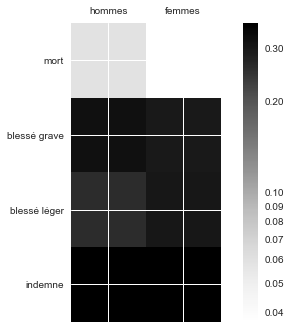

In [8]:
# Graphique mieux présenté possible ?
ct_sex_gravite_ord = np.roll(ct_sex_gravite, -1, 0)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ct_sex_gravite_ord, cmap=cm.Greys, interpolation='none',
                 norm=colors.LogNorm(vmin=ct_sex_gravite_ord.min(),
                                     vmax=ct_sex_gravite_ord.max()))
plt.colorbar(cax, format="%.2f")
ax.set_xticklabels([None, "hommes", "femmes"])
ax.set_yticklabels([None, "mort", "blessé grave", "blessé léger", "indemne"])
plt.show()

In [9]:
print("Test du chi2 : le sexe du conducteur est-il indépendant de la gravité de l’accident ?")
ct_sex_gravite_denormalized = pd.crosstab(accidents_int["grav"], accidents_int["sexe_cond"])
res_test = scs.chi2_contingency(ct_sex_gravite_denormalized)
print("La p-value est de {:.2e}.".format(res_test[1]))
print()

print("Test du chi2 : meurt-on davantage au volant si on est une femme ?")
res_test = scs.pearsonr(accidents_int['sexe_cond'],
                        accidents_int['mort'].values)
p_value = res_test[1]
if res_test[0] > 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

print("Test du chi2 : est-on davantage mort ou blessé grave si on est une femme ?")
res_test = scs.pearsonr(accidents_int['sexe_cond'],
                        accidents_int['grav_fatal'].values)
p_value = res_test[1]
if res_test[0] > 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

Test du chi2 : le sexe du conducteur est-il indépendant de la gravité de l’accident ?
La p-value est de 2.19e-31.

Test du chi2 : meurt-on davantage au volant si on est une femme ?
La p-value est de 3.55e-18.
La corrélation est de -4.05e-02.

Test du chi2 : est-on davantage mort ou blessé grave si on est une femme ?
La p-value est de 1.04e-17.
La corrélation est de -3.99e-02.



In [10]:
#Mosaic plot survivant vs. sexe
ct_survived_sex = pd.crosstab(accidents_int["mort"], accidents_int["sexe_cond"])
N = np.sum(ct_survived_sex.values)
phat = np.sum(ct_survived_sex.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_survived_sex, {False: "darkgrey", True: "black"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Sexe du conducteur", y_label="Mort",
            row_labels=["non", "oui"],
            col_labels=["homme", "femme"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

In [11]:
#Mosaic plot survivant vs. sexe
ct_grav_sex = pd.crosstab(accidents_int["grav_fatal"], accidents_int["sexe_cond"])
N = np.sum(ct_grav_sex.values)
phat = np.sum(ct_grav_sex.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_grav_sex, {False: "darkgrey", True: "black"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Sexe du conducteur", y_label="Mort ou gravement blessé",
            row_labels=["non", "oui"],
            col_labels=["homme", "femme"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

cat_age_cond         0         1         2
grav                                      
1             0.261430  0.377151  0.373985
2             0.051110  0.047453  0.089482
3             0.388145  0.299228  0.334115
4             0.299314  0.276169  0.202417



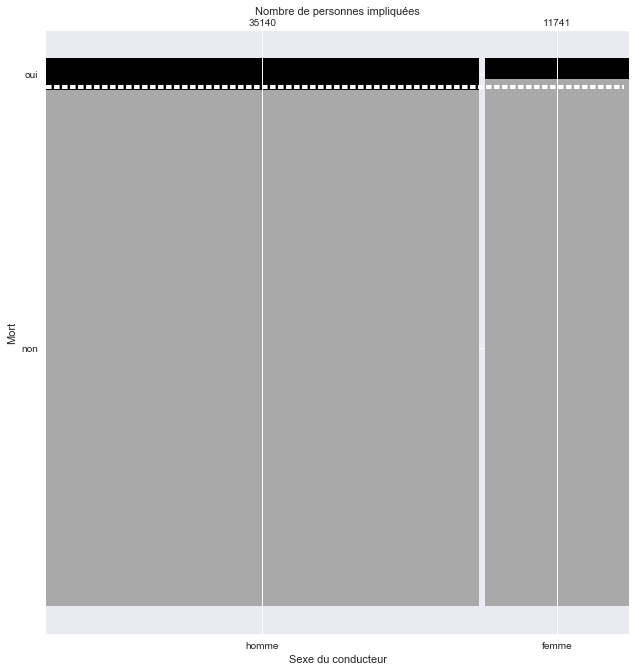

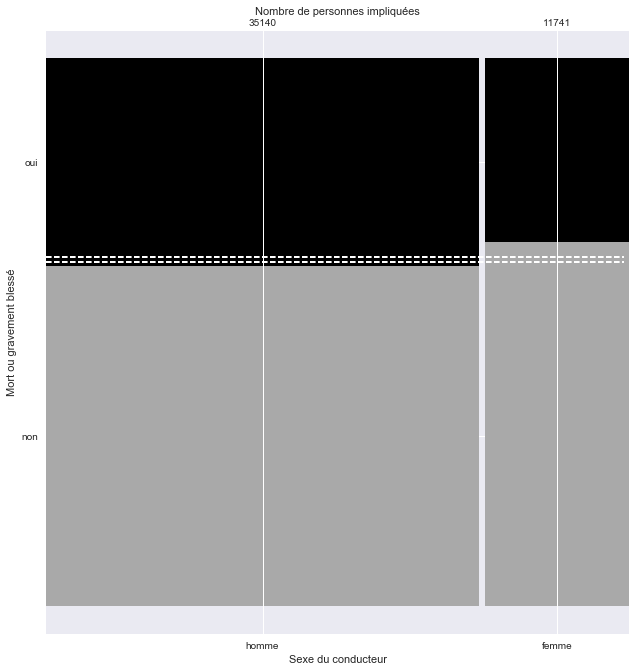

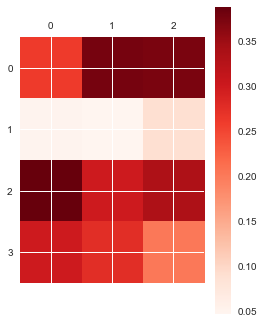

In [12]:
an_stat = 2016
accidents_int["junior"] = accidents_int["an_nais_cond"] >= an_stat - 21
accidents_int["senior"] = accidents_int["an_nais_cond"] <= an_stat - 65
accidents_int["cat_age_cond"] = 0*accidents_int["junior"] + \
                                1*(~(accidents_int["junior"] | accidents_int["senior"])) + \
                                2*accidents_int["senior"]
ct_age_gravite = pd.crosstab(accidents_int["grav"], accidents_int["cat_age_cond"], normalize="columns")
print(ct_age_gravite)
print()
plt.matshow(ct_age_gravite.values, cmap=cm.Reds, interpolation='none')
plt.colorbar()
plt.show()

In [13]:
print("Test du chi2 : l’âge du conducteur est-il indépendant de la gravité de l’accident ?")
ct_age_gravite_denormalized = pd.crosstab(accidents_int["grav"], accidents_int["cat_age_cond"])
res_test = scs.chi2_contingency(ct_age_gravite_denormalized)
print("La p-value est de {:.2e}.".format(res_test[1]))
print()


print("Test du chi2 : meurt-on davantage au volant si on est jeune ?")
res_test = scs.pearsonr(accidents_int['junior'],
                        accidents_int['mort'].values)
p_value = res_test[1]
if res_test[0] < 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()


print("Test du chi2 : meurt-on **moins** au volant si on est jeune ?")
res_test = scs.pearsonr(accidents_int['junior'],
                        accidents_int['mort'].values)
p_value = res_test[1]
if res_test[0] > 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()


print("Test du chi2 : est-on davantage mort ou blessé grave si on est un jeune ?")
res_test = scs.pearsonr(accidents_int['junior'],
                        accidents_int['grav_fatal'].values)
p_value = res_test[1]
if res_test[0] < 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))

Test du chi2 : l’âge du conducteur est-il indépendant de la gravité de l’accident ?
La p-value est de 4.94e-129.

Test du chi2 : meurt-on davantage au volant si on est jeune ?
La p-value est de 1.00e+00.
La corrélation est de -3.10e-03.

Test du chi2 : meurt-on **moins** au volant si on est jeune ?
La p-value est de 1.00e+00.
La corrélation est de -3.10e-03.

Test du chi2 : est-on davantage mort ou blessé grave si on est un jeune ?
La p-value est de 3.39e-35.
La corrélation est de 5.74e-02.


In [14]:
#Mosaic plot accident_grave vs. jeune
ct_grav_jeune = pd.crosstab(accidents_int["grav_fatal"], accidents_int["junior"])
ct_grav_jeune = ct_grav_jeune.rename(columns={False: "notyoung", True: "young"})
ct_grav_jeune = ct_grav_jeune.rename(index={False: "grav", True: "notgrav"})
print(ct_grav_jeune)
N = np.sum(ct_grav_jeune.values)
phat = np.sum(ct_grav_jeune.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_grav_jeune, {"notgrav": "black", "grav": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Âge du conducteur", y_label="Mort ou gravement blessé",
            row_labels=["non", "oui"],
            col_labels=["> 25 ans", "≤ 25 ans"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

junior      notyoung  young
grav_fatal                 
grav           26201   3434
notgrav        14556   2690


In [15]:
#Mosaic plot mort vs. jeune
ct_dead_jeune = pd.crosstab(accidents_int["mort"], accidents_int["junior"])
ct_dead_jeune = ct_dead_jeune.rename(columns={False: "notyoung", True: "young"})
ct_dead_jeune = ct_dead_jeune.rename(index={False: "dead", True: "alive"})
print(ct_dead_jeune)
N = np.sum(ct_dead_jeune.values)
phat = np.sum(ct_dead_jeune.values[1,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_dead_jeune, {"alive": "black", "dead": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Âge du conducteur", y_label="Mort",
            row_labels=["oui", "non"],
            col_labels=["> 25 ans", "≤ 25 ans"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

junior  notyoung  young
mort                   
dead       38590   5811
alive       2167    313


In [16]:
print("Test du chi2 : meurt-on davantage au volant si on est vieux ?")
res_test = scs.pearsonr(accidents_int['senior'],
                        accidents_int['mort'].values)
p_value = res_test[1]
if res_test[0] < 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

print("Test du chi2 : est-on davantage mort ou blessé grave si on est un vieux ?")
res_test = scs.pearsonr(accidents_int['senior'],
                        accidents_int['grav_fatal'].values)
p_value = res_test[1]
if res_test[0] < 0:
    p_value = 1
else:
    p_value *= 2
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

Test du chi2 : meurt-on davantage au volant si on est vieux ?
La p-value est de 3.65e-38.
La corrélation est de 5.98e-02.

Test du chi2 : est-on davantage mort ou blessé grave si on est un vieux ?
La p-value est de 9.75e-20.
La corrélation est de 4.23e-02.



In [17]:
#Mosaic plot mort vs. jeune
ct_dead_old = pd.crosstab(accidents_int["mort"], accidents_int["senior"])
ct_dead_old = ct_dead_old.rename(columns={False: "notold", True: "old"})
ct_dead_old = ct_dead_old.rename(index={False: "dead", True: "alive"})
print(ct_dead_old)
N = np.sum(ct_dead_old.values)
phat = np.sum(ct_dead_old.values[1,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_dead_old, {"alive": "black", "dead": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Âge du conducteur", y_label="Mort",
            row_labels=["oui", "non"],
            col_labels=["≤ 65 ans", "> 65 ans"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

senior  notold   old
mort                
dead     39354  5047
alive     1984   496


In [18]:
#Mosaic plot mort vs. jeune
ct_grav_old = pd.crosstab(accidents_int["grav_fatal"], accidents_int["senior"])
ct_grav_old = ct_grav_old.rename(columns={False: "notold", True: "old"})
ct_grav_old = ct_grav_old.rename(index={False: "grav", True: "notgrav"})
print(ct_grav_old)
N = np.sum(ct_grav_old.values)
phat = np.sum(ct_grav_old.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_grav_old, {"grav": "black", "notgrav": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Âge du conducteur", y_label="Mort ou gravement blessé",
            row_labels=["oui", "non"],
            col_labels=["≤ 65 ans", "> 65 ans"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

senior      notold   old
grav_fatal              
grav         26440  3195
notgrav      14898  2348


## Différence entre départementale et nationale

catr         2         3
grav                    
1     0.372185  0.358816
2     0.054765  0.052666
3     0.253648  0.323601
4     0.319402  0.264918


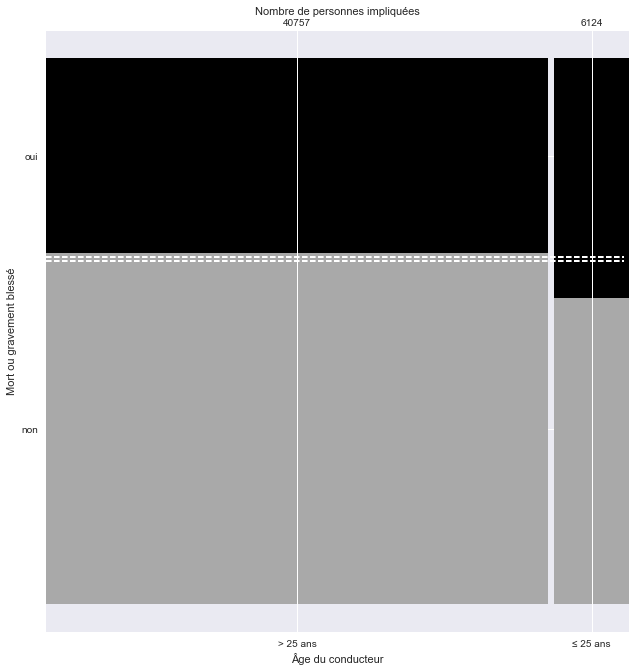

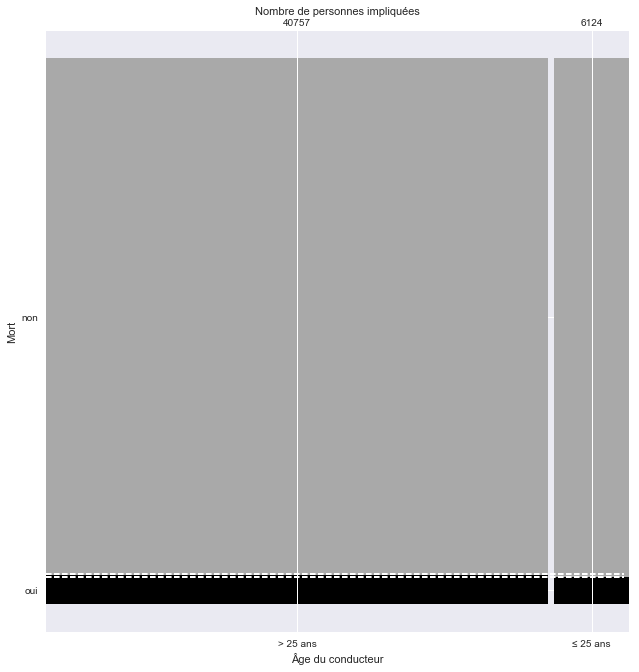

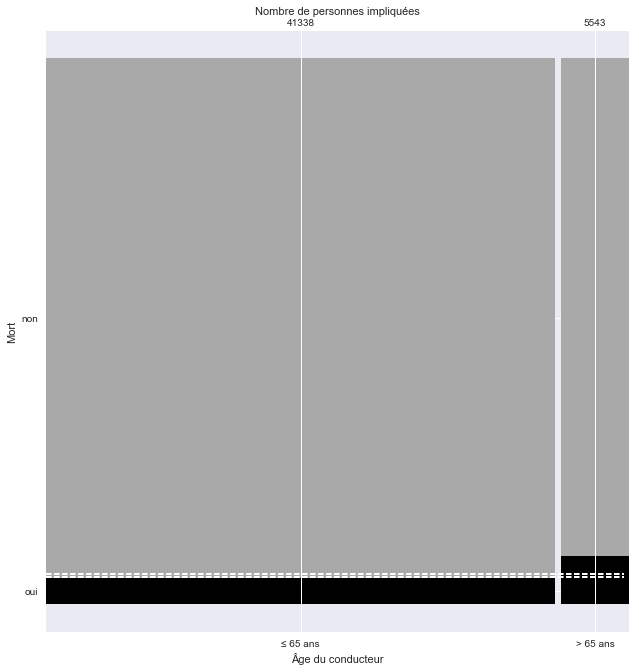

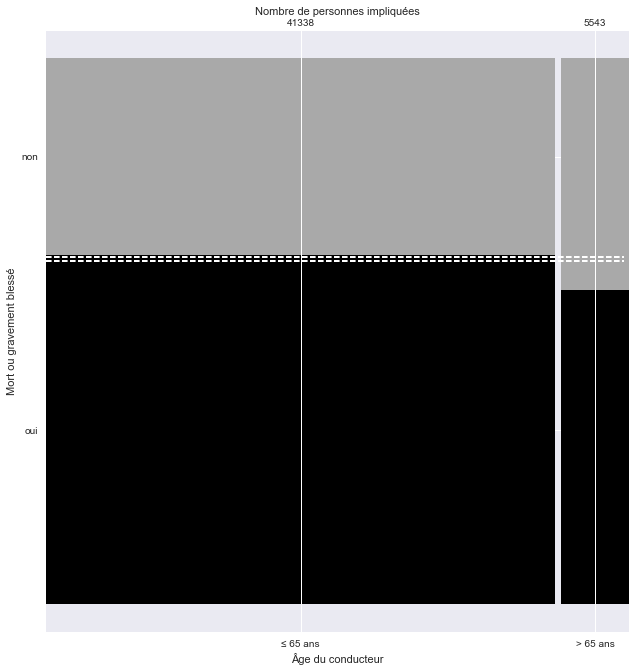

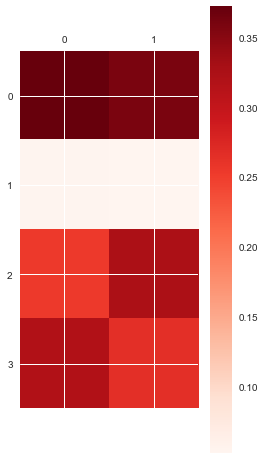

2 : nationale ; 3 : départementale
0 : indemne, 1 : mort, 2 : blessé grave, 3 : blessé léger


In [19]:
accidents_ints = dfs[2][nat_dep_non_tpc].merge(dfs[0])
accidents_int["mort"] = (accidents_int["grav"] == 2)
accidents_int["grav_fatal"] = accidents_int["grav"].isin({2,3})

ct_grav_catr = pd.crosstab(accidents_ints["grav"], accidents_ints["catr"], normalize="columns")
print(ct_grav_catr)
plt.matshow(ct_grav_catr, cmap=cm.Reds, interpolation='none')
plt.colorbar()
plt.show()
print("2 : nationale ; 3 : départementale")
print("0 : indemne, 1 : mort, 2 : blessé grave, 3 : blessé léger")

In [20]:
print("Test du chi2 : le gestionnaire de l’infrastructure est-il "\
      "indépendant de la gravité de l’accident ?")
ct_grav_catr_denormalized = pd.crosstab(accidents_int["grav"], accidents_int["catr"])
res_test = scs.chi2_contingency(ct_grav_catr_denormalized)
print("La p-value est de {:.2e}.".format(res_test[1]))
print()

print("Test du chi2 : indépendance des chances de mourir et d’être sur route nationale ?")
res_test = scs.pearsonr(accidents_int['catr'],
                        accidents_int['mort'].values)
p_value = res_test[1]
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

print("Test du chi2 : indépendance des chances de mourir ou être blessé grave et d’être sur route nationale ?")
res_test = scs.pearsonr(accidents_int['catr'],
                        accidents_int['grav_fatal'].values)
p_value = res_test[1]
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))

Test du chi2 : le gestionnaire de l’infrastructure est-il indépendant de la gravité de l’accident ?
La p-value est de 1.20e-28.

Test du chi2 : indépendance des chances de mourir et d’être sur route nationale ?
La p-value est de 6.40e-01.
La corrélation est de -2.16e-03.

Test du chi2 : indépendance des chances de mourir ou être blessé grave et d’être sur route nationale ?
La p-value est de 2.59e-23.
La corrélation est de 4.59e-02.


In [21]:
#Mosaic plot mort vs. jeune
ct_grav_catr = pd.crosstab(accidents_int["grav_fatal"], accidents_int["catr"])
ct_grav_catr = ct_grav_catr.rename(index={True: "grav", False: "notgrav"})
print(ct_grav_old)
N = np.sum(ct_grav_old.values)
phat = np.sum(ct_grav_old.values[1,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_grav_catr, {"grav": "black", "notgrav": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Catégorie de la route", y_label="Mort ou gravement blessé",
            row_labels=["oui", "non"],
            col_labels=["départementale", "nationale"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

senior      notold   old
grav_fatal              
grav         26440  3195
notgrav      14898  2348


In [22]:
#Mosaic plot mort vs. jeune
ct_mort_catr = pd.crosstab(accidents_int["grav_fatal"], accidents_int["catr"])
ct_mort_catr = ct_mort_catr.rename(index={True: "dead", False: "alive"})
print(ct_mort_catr)
N = np.sum(ct_mort_catr.values)
phat = np.sum(ct_mort_catr.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_mort_catr, {"dead": "black", "alive": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Catégorie de la route", y_label="Mort",
            row_labels=["non", "oui"],
            col_labels=["départementale", "nationale"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

catr           2      3
grav_fatal             
alive       3820  25815
dead        1694  15552


In [23]:
accidents_nat_dep = accidents[ accidents['catr'].isin({2,3})]
accidents_nat_dep["mort"] = (accidents_int["grav"] == 2)
accidents_nat_dep["grav_fatal"] = accidents_nat_dep["grav"].isin({2,3})
accidents_nat_dep["is_bidir"] = accidents_nat_dep["circ"] == 3

print("Test du chi2 : la bidirectionnalité est-elle indépendante de"\
      "indépendant de la gravité de l’accident ?")
ct_grav_bidir_denormalized = pd.crosstab(accidents_nat_dep["grav"], accidents_nat_dep["is_bidir"])
res_test = scs.chi2_contingency(ct_grav_bidir_denormalized)
print("La p-value est de {:.2e}.".format(res_test[1]))
print()

print("Test du chi2 : indépendance des chances de mourir et d’être sur route bidirectionnelle ?")
res_test = scs.pearsonr(accidents_nat_dep['is_bidir'],
                        accidents_nat_dep['mort'])
p_value = res_test[1]
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))
print()

print("Test du chi2 : indépendance des chances de mourir ou être blessé grave et d’être sur route bidirectionnelle ?")
res_test = scs.pearsonr(accidents_nat_dep['is_bidir'],
                        accidents_nat_dep['grav_fatal'])
p_value = res_test[1]
print("La p-value est de {:.2e}.".format(p_value))
print("La corrélation est de {:.2e}.".format(res_test[0]))

Test du chi2 : la bidirectionnalité est-elle indépendante deindépendant de la gravité de l’accident ?
La p-value est de 5.52e-168.

Test du chi2 : indépendance des chances de mourir et d’être sur route bidirectionnelle ?
La p-value est de 1.00e+00.
La corrélation est de nan.

Test du chi2 : indépendance des chances de mourir ou être blessé grave et d’être sur route bidirectionnelle ?
La p-value est de 8.85e-156.
La corrélation est de -1.14e-01.


D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

D:\Users\eric.benhamou\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [24]:
#Mosaic plot mort vs. route_bidirectionnelle
ct_mort_bidir = pd.crosstab(accidents_nat_dep["mort"], accidents_nat_dep["is_bidir"])
ct_mort_bidir = ct_mort_bidir.rename(index={True: "dead", False: "alive"})
ct_mort_bidir = ct_mort_bidir.rename(columns={True: "bidir", False: "notbidir"})
print(ct_mort_bidir)
N = np.sum(ct_mort_bidir.values)
phat = np.sum(ct_mort_bidir.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_mort_bidir, {"dead": "black", "alive": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Route bidirectionnelle", y_label="Mort",
            row_labels=["non", "oui"],
            col_labels=["oui", "non"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

is_bidir  notbidir  bidir
mort                     
alive        26709   1604
dead          1510     71


In [25]:
#Mosaic plot mort vs. route_bidirectionnelle
ct_grav_bidir = pd.crosstab(accidents_nat_dep["grav_fatal"], accidents_nat_dep["is_bidir"])
ct_grav_bidir = ct_grav_bidir.rename(index={True: "dead", False: "alive"})
print(ct_grav_bidir)
N = np.sum(ct_grav_bidir.values)
phat = np.sum(ct_grav_bidir.values[0,:]) / N
deltap = scs.norm.ppf(.975) * np.sqrt(phat * (1-phat) / N)
mosaic_plot(ct_grav_bidir, {"dead": "black", "alive": "darkgrey"}, figsize=(10,10), pad_x=.01, pad_y=0,
            x_label="Route bidirectionnelle", y_label="Mort ou blessé grave",
            row_labels=["non", "oui"],
            col_labels=["oui", "non"],
            top_label="Nombre de personnes impliquées",
            lines=[(phat+deltap, "w--", {"linewidth": 2}),
                   (phat-deltap, "w--", {"linewidth": 2})])

is_bidir    False  True 
grav_fatal              
alive       29752   5654
dead        17344   1485


# Éclairage

lum          1         2         3         4         5
grav                                                  
1     0.358767  0.351150  0.344315  0.377841  0.391753
2     0.052318  0.060577  0.065383  0.048295  0.039550
3     0.318473  0.319404  0.362561  0.318182  0.252296
4     0.270442  0.268869  0.227741  0.255682  0.316401


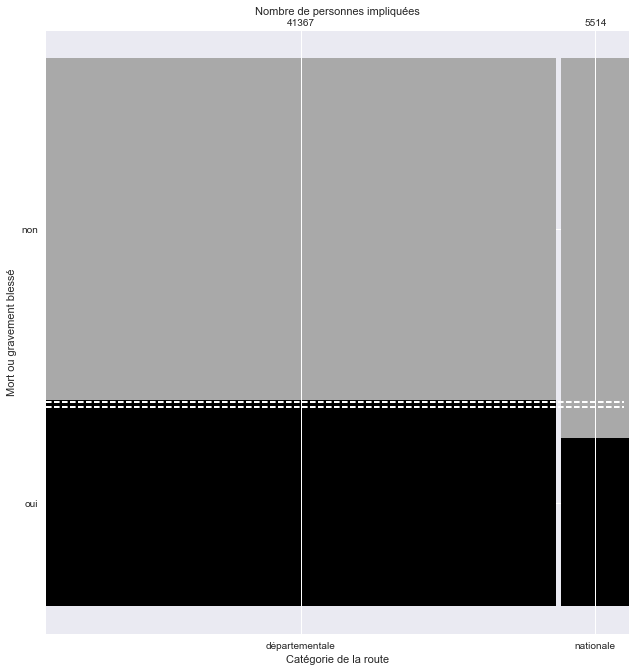

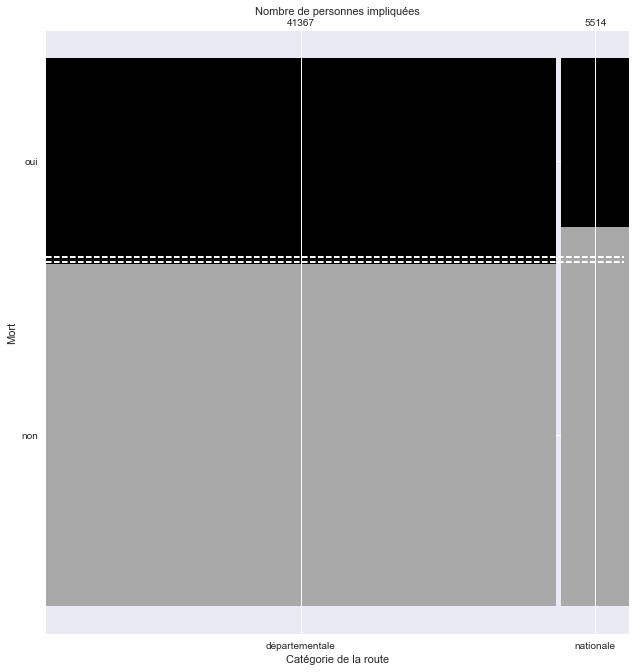

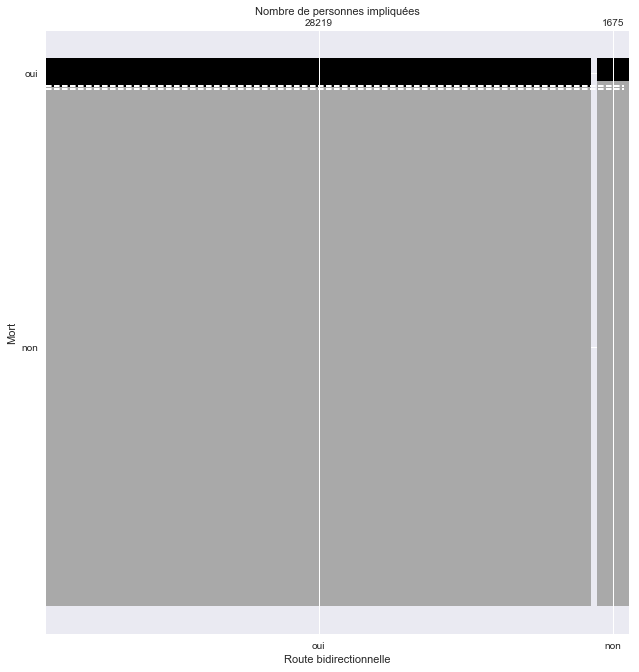

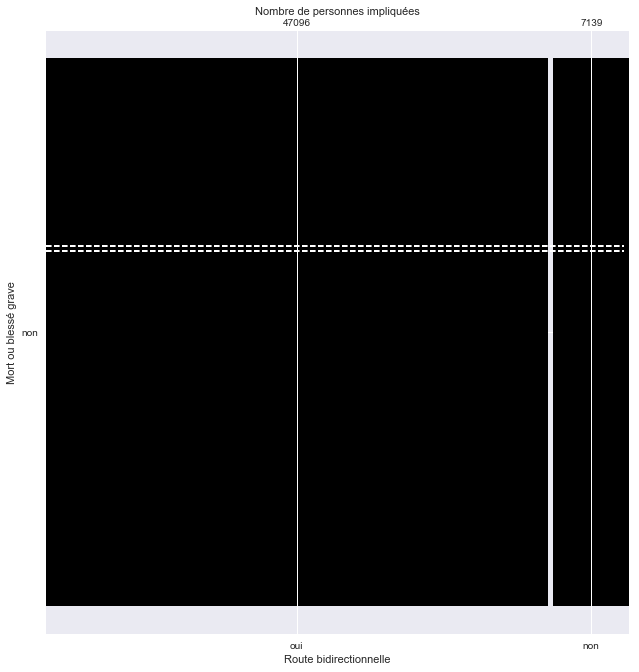

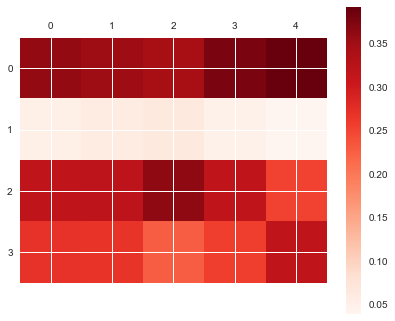

In [26]:
accidents_int = accidents_int.merge(dfs[3])
ct_lum_grav = pd.crosstab(accidents_ints["grav"], accidents_int["lum"], normalize="columns")
print(ct_lum_grav)
plt.matshow(ct_lum_grav, cmap=cm.Reds, interpolation='none')
plt.colorbar()
plt.show()

In [27]:
files = ["usagers", "vehicules","lieux", "caracteristiques"]
for i, file in enumerate(files):
    print( file, " shape", dfs[i].shape )

usagers  shape (133422, 12)
vehicules  shape (101924, 9)
lieux  shape (59432, 18)
caracteristiques  shape (59432, 16)


In [28]:
# hello
pd.options.display.float_format = '{:,.2f}'.format
for i, file in enumerate(files):
    df_0 =dfs[i].drop('Num_Acc',axis=1)
    if len(df_0.columns)>11:
        print(df_0.drop(df_0.columns[11:],axis=1).describe().to_latex())
        print(df_0.drop(df_0.columns[:11],axis=1).describe().to_latex())
    else:
        print(df_0.describe().to_latex())
    print('\captionof{table}{Descriptive stats for ', file, '}\n\\vspace{0.5cm}\n\n')

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &      place &       catu &       grav &       sexe &     trajet &       secu &       locp &       actp &      etatp &    an\_nais \\
\midrule
count & 121,591.00 & 133,422.00 & 133,422.00 & 133,422.00 & 133,412.00 & 124,062.00 & 133,333.00 & 133,328.00 & 133,327.00 & 133,390.00 \\
mean  &       1.33 &       1.35 &       2.50 &       1.30 &       3.00 &      16.97 &       0.25 &       0.29 &       0.11 &   1,977.39 \\
std   &       0.90 &       0.64 &       1.33 &       0.46 &       2.66 &      16.43 &       0.91 &       1.08 &       0.39 &      18.66 \\
min   &       1.00 &       1.00 &       1.00 &       1.00 &       0.00 &       1.00 &       0.00 &       0.00 &       0.00 &   1,911.00 \\
25\%   &       1.00 &       1.00 &       1.00 &       1.00 &       0.00 &      11.00 &       0.00 &       0.00 &       0.00 &   1,965.00 \\
50\%   &       1.00 &       1.00 &       3.00 &       1.00 &       4.00 &      11.00 &       0.00 &       0.00 &       0

In [29]:
dfs[2].drop(['situ', 'env1'],axis=1).describe().to_latex()
len(dfs[2].columns[12:])


6